In [2]:
import sys
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from spender.flow import NeuralDensityEstimator
import matplotlib.pyplot as plt

In [3]:
# use tex
plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
})

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
blob = torch.load('../desi_noise_spender_10latent_space.pt', map_location='cpu')
theta = blob['latents'].float()   # [N, 10]
A = blob['A'].float() # [N, 1]

print("latents shape:", theta.shape, theta.device)
print("A shape:", A.shape, A.device)

N, n_latent = theta.shape
context_dim = A.shape[1]

latents shape: torch.Size([254976, 10]) cpu
A shape: torch.Size([254976, 1]) cpu


In [6]:
perm = torch.randperm(N)
n_train = int(0.85 * N)
train_theta = theta[perm[:n_train]]
valid_theta = theta[perm[n_train:]]
train_A = A[perm[:n_train]]
valid_A = A[perm[n_train:]]

print("N_train:", n_train, "N_valid:", N - n_train)

N_train: 216729 N_valid: 38247


In [7]:
batch_size = 10_000

train_ds = TensorDataset(train_theta, train_A)
valid_ds = TensorDataset(valid_theta, valid_A)

data_loader = DataLoader(train_ds, batch_size=batch_size,
                         shuffle=True, drop_last=True)
valid_data_loader = DataLoader(valid_ds, batch_size=batch_size,
                               shuffle=False)

In [8]:
flow_file = 'desi_noise_spender_10latent_flow.pt'
print("flow_file:", flow_file)

flow_file: desi_noise_spender_10latent_flow.pt


In [ ]:
mu = train_theta.mean(0)
sigma = train_theta.std(0)
initial_pos = {
    "bounds": [[m.item(), m.item()] for m in mu],
    "std": [s.item() for s in sigma],
}

In [21]:
NDE_theta = NeuralDensityEstimator(
        dim=n_latent,
        initial_pos=initial_pos,
        hidden_features=64,
        num_transforms=5,
        context_features=context_dim,
    )
NDE_theta.load_state_dict(torch.load(flow_file, map_location=device))
NDE_theta.to(device)

NeuralDensityEstimator(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineTransform()
      (1): CompositeTransform(
        (_transforms): ModuleList(
          (0-4): 5 x CompositeTransform(
            (_transforms): ModuleList(
              (0): MaskedAffineAutoregressiveTransform(
                (autoregressive_net): MADE(
                  (initial_layer): MaskedLinear(in_features=10, out_features=64, bias=True)
                  (context_layer): Linear(in_features=1, out_features=64, bias=True)
                  (blocks): ModuleList(
                    (0-1): 2 x MaskedFeedforwardBlock(
                      (linear): MaskedLinear(in_features=64, out_features=64, bias=True)
                      (dropout): Dropout(p=0.0, inplace=False)
                    )
                  )
                  (final_layer): MaskedLinear(in_features=64, out_features=20, bias=True)
                )
              )
              (1): RandomPermutation()
     

In [12]:
with torch.no_grad():
    samples = NDE_theta.sample(250, context=valid_A.to(device))# (n_sims, n_samples, n_latent)
    # make it (n_samples, n_sims, n_latent)
    samples = np.swapaxes(samples.cpu().numpy(), 0, 1)  # (n_samples, n_sims, n_latent)

In [23]:
valid_A.shape

torch.Size([38247, 1])

In [13]:
from tarp import get_tarp_coverage

theta_samp = valid_theta.cpu().numpy()  # (n_sims, n_latent)
ecp, alpha = get_tarp_coverage(samples, theta_samp, references="random", metric="euclidean", num_alpha_bins=None)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '$\\mathdefault{−0.2}$'),
  Text(0, 0.0, '$\\mathdefault{0.0}$'),
  Text(0, 0.2, '$\\mathdefault{0.2}$'),
  Text(0, 0.4000000000000001, '$\\mathdefault{0.4}$'),
  Text(0, 0.6000000000000001, '$\\mathdefault{0.6}$'),
  Text(0, 0.8, '$\\mathdefault{0.8}$'),
  Text(0, 1.0000000000000002, '$\\mathdefault{1.0}$'),
  Text(0, 1.2000000000000002, '$\\mathdefault{1.2}$')])

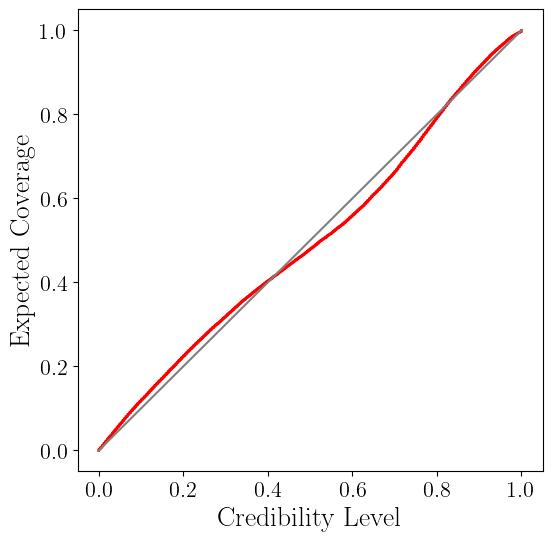

In [51]:
plt.figure(figsize=(6, 6), dpi=100)
plt.plot(alpha, ecp, linestyle='-', color='red', lw=2)
plt.plot([0, 1], [0, 1], color='gray')
plt.xlabel('Credibility Level', fontsize=20)
plt.ylabel('Expected Coverage', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [15]:
def load_model(filename, models, instruments):
    device = instruments[0].wave_obs.device
    model_struct = torch.load(filename, map_location=device, weights_only=False)
    #wave_rest = model_struct['model'][0]['decoder.wave_rest']
    for i, model in enumerate(models):
        # backwards compat: encoder.mlp instead of encoder.mlp.mlp
        if 'encoder.mlp.mlp.0.weight' in model_struct['model'][i].keys():
            from collections import OrderedDict
            model_struct['model'][i] = OrderedDict([(k.replace('mlp.mlp', 'mlp'), v) for k, v in model_struct['model'][i].items()])
        # backwards compat: add instrument to encoder
        try:
            model.load_state_dict(model_struct['model'][i], strict=False)
        except RuntimeError:
            model_struct['model'][i]['encoder.instrument.wave_obs']= instruments[i].wave_obs
            model_struct['model'][i]['encoder.instrument.skyline_mask']= instruments[i].skyline_mask
            model.load_state_dict(model_struct[i]['model'], strict=False)

    losses = model_struct['losses']
    return models, losses

In [16]:
from spender.data import desi
from spender.model import SpectrumAutoencoder

import torch.nn as nn

/Users/ng27753/Astronomy_Research/spender/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [21]:
inst = desi.DESI()

lmbda_min = inst.wave_obs[0]
lmbda_max = inst.wave_obs[-1]
bins = int((lmbda_max-lmbda_min).item()/0.8)
wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)

In [24]:
n_hidden = (64, 256, 1024)
model_spender = SpectrumAutoencoder(inst,
                                   wave_rest,
                                   n_latent=10,
                                   n_hidden=n_hidden,
                                   act=[nn.LeakyReLU()]*(len(n_hidden)+1)
                                   )


In [25]:
models, losses = load_model('../desi_noise_spender_10latent.pt', [model_spender], [inst])

model_spender = models[0]

In [26]:
with torch.no_grad():
    model_spender.eval()
    inst.eval()

    noise_sample_maf = model_spender.decode(torch.tensor(samples[:, 0]))
    noise_theta = model_spender.decode(torch.tensor(theta_samp[0]))

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, -20.0, '$\\mathdefault{−20}$'),
  Text(0, 0.0, '$\\mathdefault{0}$'),
  Text(0, 20.0, '$\\mathdefault{20}$'),
  Text(0, 40.0, '$\\mathdefault{40}$'),
  Text(0, 60.0, '$\\mathdefault{60}$'),
  Text(0, 80.0, '$\\mathdefault{80}$'),
  Text(0, 100.0, '$\\mathdefault{100}$'),
  Text(0, 120.0, '$\\mathdefault{120}$')])

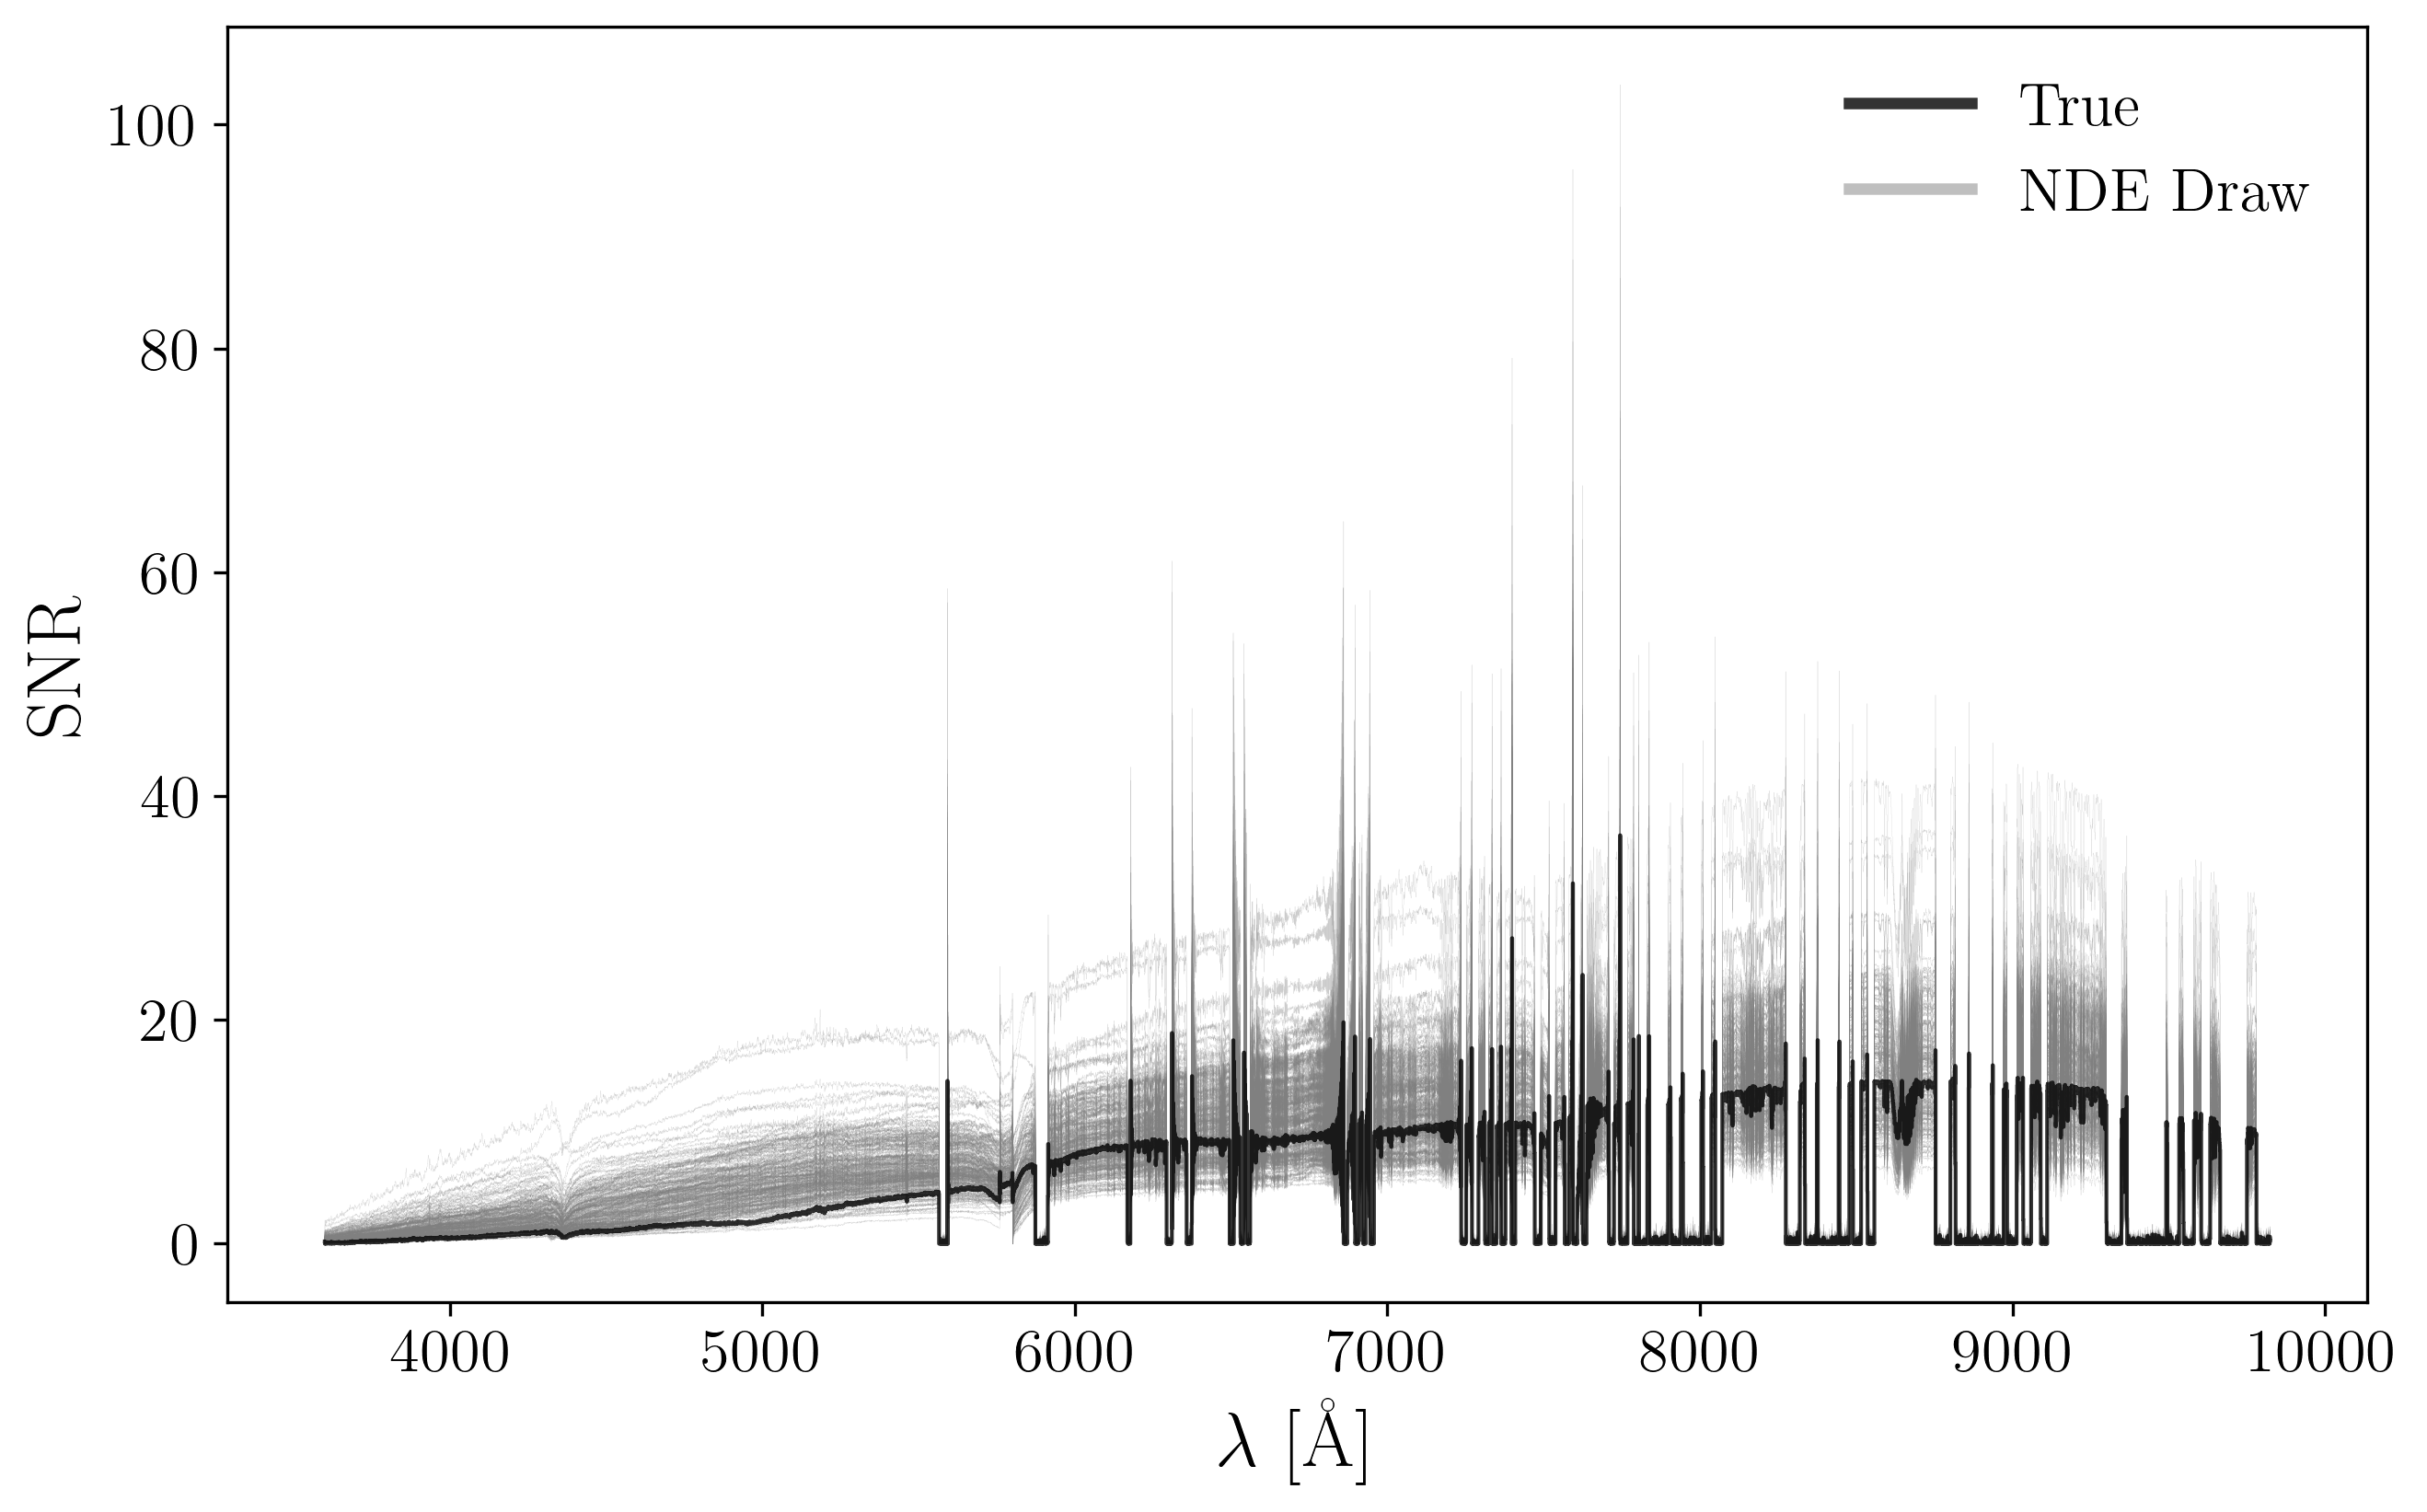

In [46]:
plt.figure(figsize=(10, 6), dpi=300)
for sa in noise_sample_maf:
    # print(sa[0])
    plt.step(wave_rest.numpy(), sa.numpy(), where='mid', label='_sample', lw=0.05, alpha=0.5, color='gray')

plt.step(wave_rest.numpy(), noise_theta.numpy(), where='mid', label='_true', color='black', lw=1., alpha=0.8)

# gray is sample and black is true make a legend
plt.plot([], [], color='black', label='True', lw=3, alpha=0.8)
plt.plot([], [], color='gray', label='NDE Draw', lw=3, alpha=0.5)
plt.legend(fontsize=16, loc='upper right', frameon=False)

plt.xlabel(r'$\lambda$ [\AA]', fontsize=20)
plt.ylabel('SNR', fontsize=20)

# ticks fontsize
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [31]:
import pickle

with open('../DATA/DESIchunk1024_0.pkl', 'rb') as f:
    desi_data = pickle.load(f)

In [39]:
desi_data[2].shape

torch.Size([1024])